In [1]:
import datetime
import numpy as np
import pandas as pd
import math

# 0. 设置基础参数

In [2]:
class Para():
    # - 文件路径
    path_tradingday = '../Data/data/tradingdays/tradingdays.csv'
    path_financial = '../Data/data/financial/financial_'
    path_dailyquote = '../Data/data/daily_quote/daily_quote_'
    path_analyst = '../Data/data/analyst/analyst_'

    # - 数据范围
    begin_year = 2012
    end_year = 2014

    # - 极端值判断范围
    n_extreme = 20

    # - 训练集和测试集
    begin_timeindex = 0
    end_timeindex = 500
    in_sample_rate = 0.6
    time_in_sample = range(begin_timeindex, begin_timeindex+int((end_timeindex - begin_timeindex) * in_sample_rate) + 1)
    time_test = range(begin_timeindex+int((end_timeindex - begin_timeindex) * in_sample_rate) + 1, end_timeindex + 1)

    # - 交叉检验参数
    evaluation_metrics = 'cross_val_score'  # 'cross_val_score' 'cross_validate'
    cv = 5  # k value in k-folder
    percent_cv = 0.1  # -- percentage of cross validation samples

    # - 模型参数
    method = 'XGBOOST-C'  # 'LOGI' 'XGBOOST-C' 'LR'
    percent_select = [0.3, 0.3]  # -- 30% positive samples, 30% negative samples

    seed = 42  # -- random seed

    # - logistic模型参数
    logi_c = 0.0006  # -- logistic regression parameter

    # - xgboost模型参数
    xgbc_n_estimators = 100  # -- xgboost classifier parameter
    xgbc_learning_rate = 0.1  # -- xgboost classifier parameter
    xgbc_subsample_C = 0.95  # -- xgboost classifier parameter
    xgbc_max_depth = 3  # -- xgboost classifier parameter

# 1. 读入数据

## 1.1 读取财务报表、日交易、分析师一致预测的数据

In [3]:
def ReadData(doc, begin, end):
    """
    doc: 读取数据的地址，str
    begin: 开始年份, int
    end: 结束年份, int
    """
    df = pd.DataFrame()
    print("begin reading!")
    for year in range(begin, end + 1):
        path = doc + str(year) + ".csv"
        print(path)
        data = pd.read_csv(path)
        data['year'] = year
        df = pd.concat([df, data], ignore_index=True)

    print("end reading!")

    return df

##  1.2 读取交易日数据

In [4]:
def ReadTradingDay(para):
    """
    TradingDay：交易日期, datetime
    year: TradingDay的年， int
    month：TradingDay的月， int
    day： TradingDay的日， int
    """
    df = pd.read_csv(para.path_tradingday)
    df['TradingDay'] = pd.to_datetime(df['TradingDay'])
    df['year'] = df['TradingDay'].dt.year
    df['month'] = df['TradingDay'].dt.month
    df['day'] = df['TradingDay'].dt.day
    df['TimeIndex'] = range(len(df))

    return df

# 2. 生成因子数据

# 2.1 基于财务数据的因子数据

In [5]:
def Financial_Factor(df):
    """
    df:财务数据
    SecuCode：股票代码, int
    year：报表年份, int
    InfoPublDate: 公告时间， datetime
    ROE: Return on Equity，净资产收益率，质量因子
    dROE: 净资产收益率变动
    EPS: 每股收益
    dEPS: 每股收益变动
    NAPS: 每股净资产
    DP: 应付股利
    NPT: 净利润
    NPG: 净利润增长率
    """
    df = df.drop_duplicates(['SecuCode', 'year'])  # 对于同一个股票同一年份的数据保留其中一个
    df = df.sort_values(by=['SecuCode', 'year'])
    # col = df.pop('year')
    # df.insert(loc=1, column = 'year', value = col)

    new_df = pd.DataFrame()
    new_df['SecuCode'] = df['SecuCode']
    new_df['year'] = df['year']
    new_df['ROE'] = df['ROE']
    new_df['dROE'] = df['ROE'].diff()
    new_df.loc[df['year'] == 2010, 'dROE'] = new_df.loc[df['year'] == 2011, 'dROE']
    new_df['EPS'] = df['EPS']
    # new_df['dEPS'] = df['EPS'].diff()
    # new_df.loc[df['year']==2010, 'dEPS'] = new_df.loc[df['year']==2011, 'dEPS']
    new_df['NAPS'] = df['NAPS']
    # new_df['DP'] = df['DividendPayable']
    new_df['NPT'] = df['NetProfit']
    new_df['NPG'] = df['NetProfit'].diff() / df['NetProfit']

    return new_df

## 2.2 基于分析师数据的因子数据

In [6]:
def Analyst_Factor(df):
    """
    EEPS：一致预期
    ENPYOY：一致预期净利同比
    ENPYOY2：两年预期净利复合增长率
    """
    new_df = pd.DataFrame()
    new_df['SecuCode'] = df['SecuCode']
    new_df['TradingDay'] = pd.to_datetime(df['TradingDay'])
    new_df['year'] = new_df['TradingDay'].dt.year
    new_df['month'] = new_df['TradingDay'].dt.month
    new_df['day'] = new_df['TradingDay'].dt.day
    new_df['EEPS'] = df['eps_est1']
    new_df['ENPYOY'] = df['npyoy_est']
    new_df['ENPYOY2'] = df['npyoy2_est']
    new_df = new_df.sort_values(by=['SecuCode', 'TradingDay'])

    return new_df

## 2.3 基于日交易数据的因子数据

In [7]:
def Daily_Quote_Factor(df):
    """
    SecuCode：股票代码, int
    TradingDay：交易日期, datetime
    year: TradingDay的年， int
    month：TradingDay的月， int
    day： TradingDay的日， int
    Size：市值
    REV：日收益率
    REV20：反转因子，REV_t-REV_(t-20)
    VOL：换手率
    VOL20：反转因子，VOL_t-VOL_(t-20)
    STD：波动率，（最高价-最低价）/日均交易价
    """
    new_df = pd.DataFrame()
    new_df['SecuCode'] = df['SecuCode']
    new_df['TradingDay'] = pd.to_datetime(df['TradingDay'])
    new_df['year'] = new_df['TradingDay'].dt.year
    new_df['month'] = new_df['TradingDay'].dt.month
    new_df['day'] = new_df['TradingDay'].dt.day
    new_df['Size'] = df['Ashares'] * df['TurnoverValue'] / df['TradingVolumes']
    new_df['Size'] = new_df['Size'].apply(np.log)
    new_df['REV'] = df['ret']
    new_df['VOL'] = df['TradingVolumes'] / df['AFloats']
    new_df['STD'] = (df['HighPrice'] - df['LowPrice']) / (df['TurnoverValue'] / df['TradingVolumes'])
    new_df = new_df.sort_values(by=['SecuCode', 'TradingDay'])
    new_df['REV20'] = new_df['REV'] - new_df['REV'].shift(20)
    new_df['VOL20'] = new_df['VOL'] - new_df['VOL'].shift(20)

    return new_df

##  2.4 合并因子数据

In [8]:
def MergeFactors(para, df_f, df_a, df_dq):
    """
    df_f: 财务数据，年度数据
    df_a: 分析师一致预测数据，日度数据
    df_dq: 日交易数据， 日度数据
    """
    df_merge = df_dq.merge(df_a, on=['year', 'month', 'day', 'SecuCode', 'TradingDay'])
    df_merge = df_merge.merge(df_f, on=['SecuCode', 'year'])
    df_td = ReadTradingDay(para)
    df_merge = df_merge.merge(df_td, on=['year', 'month', 'day', 'TradingDay'])
    col = df_merge.pop('TimeIndex')
    df_merge.insert(loc=5, column='TimeIndex', value=col)
    col = df_merge.pop('REV')
    df_merge.insert(loc=6, column='REV', value=col)

    return df_merge

# 3. 数据处理

## 3.1 提取因子名称

In [9]:
def FactorName(df):
    a_factor_name = df.columns
    a_factor_name = list(a_factor_name)
    a_factor_name = a_factor_name[7:]

    # for a_factor in a_factor_name:
    # print(a_factor,type(a_factor))

    return a_factor_name

## 3.2 去除极端值

In [10]:
def ExtremeValueHandling(para, df, afactor_name):
    """
    df：DataFrame数据
    factor：为需要去极值的列名称，str
    n： 判断极值上下边界的常数， int
    """
    #
    n = para.n_extreme
    # 提取该列的数据
    ls_raw = np.array(df[afactor_name].values)
    # 删除缺失值
    ls_raw = ls_raw[~np.isnan(ls_raw)]
    # 排序 axis=0，按列排列
    ls_raw.sort(axis=0)
    # 获取中位数
    dm = np.median(ls_raw)

    # 计算离差值
    ls_deviation = abs(ls_raw - dm)
    # 排序
    ls_deviation.sort(axis=0)
    # 获取离差中位数
    dmad = np.median(ls_deviation)

    # 将大于中位数n倍离差中位数的值赋为NaN
    df.loc[df[afactor_name] >= dm + n * dmad, afactor_name] = None
    # 将小于中位数n倍离差中位数的值赋为NaN
    df.loc[df[afactor_name] <= dm - n * dmad, afactor_name] = None

    return df

## 3.3 缺失值处理

In [11]:
def MissingDataHandling(df, afactor_name):
    """
    df：DataFrame数据
    factor：为需要去缺失值的列名称，str
    用每列的中位数填补缺失值
    """

    # 提取该列的数据
    ls_raw = np.array(df[afactor_name].values)
    # 删除缺失值
    ls_raw = ls_raw[~np.isnan(ls_raw)]
    # 排序 axis=0，按列排列
    ls_raw.sort(axis=0)
    # 获取中位数
    dm = np.median(ls_raw)
    # 填补缺失值
    df[afactor_name] = df[afactor_name].fillna(dm)

    return df

## 3.4 标准化处理

In [12]:
def Standardize(df, afactor_name):
    """
    df：DataFrame数据
    factor：为需要去缺失值的列名称，str
    """
    df[afactor_name] = (df[afactor_name] - df[afactor_name].mean()) / df[afactor_name].std()

    return df

## 3.5 生产完整的因子数据

In [13]:
# - 3.5 生产完整的因子数据
def GenerateFactorData(para):
    print('# READING Model')
    financial_factor = Financial_Factor(ReadData(para.path_financial, para.begin_year, para.end_year))
    daily_quote_factor = Daily_Quote_Factor(ReadData(para.path_dailyquote, para.begin_year, para.end_year))
    analyst_factor = Analyst_Factor(ReadData(para.path_analyst, para.begin_year, para.end_year))
    df_factor = MergeFactors(para, financial_factor, analyst_factor, daily_quote_factor)
    afactor_name = FactorName(df_factor)

    for afactor in afactor_name:
        # print(afactor)
        df_factor = ExtremeValueHandling(para, df_factor, afactor)
        df_factor = MissingDataHandling(df_factor, afactor)
        df_factor = Standardize(df_factor, afactor)

    df_factor = df_factor.sort_values(by=['TradingDay', 'SecuCode'])

    # -- 更新参数
    para.begin_timeindex = df_factor['TimeIndex'].min()
    para.end_timeindex = df_factor['TimeIndex'].max()
    para.time_in_sample = range(para.begin_timeindex,
                                para.begin_timeindex+int((para.end_timeindex - para.begin_timeindex) * para.in_sample_rate) + 1)
    para.time_test = range(para.begin_timeindex+int((para.end_timeindex - para.begin_timeindex) * para.in_sample_rate) + 1,
                           para.end_timeindex + 1)

    return df_factor

# 4. 设置模型

## 4.1 筛选出收益最高和最低的n只股票

In [14]:
def label_data(data):
    # -- label data
    data = data.copy()
    data['REV_bin'] = np.nan

    # -- sort by return
    data = data.sort_values(by='REV', ascending=False)

    # -- decide the amount of stocks selected
    n_stock_select = np.multiply(para.percent_select, data.shape[0])
    n_stock_select = np.around(n_stock_select).astype(int)

    # -- assign 1 or 0
    data.iloc[0:n_stock_select[0], -1] = 1
    data.iloc[-n_stock_select[1]:, -1] = 0

    # -- remove other stocks
    data = data.dropna(axis=0)

    return data

In [15]:
para = Para()
df = GenerateFactorData(para)

print('# TESTING Model')
print('Total TimeIndex:[', str(para.begin_timeindex), ',', str(para.end_timeindex), ']')
print('Test TimeIndex(in-sample):[', str(para.begin_timeindex), ',',
      str(para.begin_timeindex+int((para.end_timeindex - para.begin_timeindex) * para.in_sample_rate)), ']')
print('Predict TimeIndex(out-sample):[',
      str(para.begin_timeindex+int((para.end_timeindex - para.begin_timeindex) * para.in_sample_rate) + 1), ',', str(para.end_timeindex),
      ']')

# READING Model
begin reading!
../Data/data/financial/financial_2012.csv
../Data/data/financial/financial_2013.csv
../Data/data/financial/financial_2014.csv
end reading!
begin reading!
../Data/data/daily_quote/daily_quote_2012.csv
../Data/data/daily_quote/daily_quote_2013.csv
../Data/data/daily_quote/daily_quote_2014.csv
end reading!
begin reading!
../Data/data/analyst/analyst_2012.csv
../Data/data/analyst/analyst_2013.csv
../Data/data/analyst/analyst_2014.csv
end reading!
# TESTING Model
Total TimeIndex:[ 486 , 1211 ]
Test TimeIndex(in-sample):[ 486 , 921 ]
Predict TimeIndex(out-sample):[ 922 , 1211 ]


In [16]:
df

,SecuCode,TradingDay,year,month,day,TimeIndex,REV,Size,VOL,STD,...,VOL20,EEPS,ENPYOY,ENPYOY2,ROE,dROE,EPS,NAPS,NPT,NPG
0,1,2012-01-04,2012,1,4,486,-0.027582,3.040370,-0.695873,-0.379301,...,0.007258,2.623881,-0.245580,0.046950,0.825761,0.007032,2.468009,1.638288,-0.304158,0.119844
1,2,2012-01-04,2012,1,4,486,-0.018742,2.954837,-0.559838,0.379562,...,-1.529719,0.990549,0.179699,-0.132072,0.614567,0.084747,0.395199,-0.131235,-0.304158,-0.269944
2,4,2012-01-04,2012,1,4,486,-0.022250,-1.946598,-0.516394,-0.020632,...,-1.110287,-0.977117,-0.732346,-1.756693,0.574750,0.007032,-0.558660,-1.146062,-0.542640,1.032348
3,5,2012-01-04,2012,1,4,486,0.000000,-0.177588,-0.890974,-0.248703,...,-2.347293,-0.952415,-0.732346,3.244643,-0.923571,-0.218929,-0.815468,-1.184600,-0.639843,1.645282
4,6,2012-01-04,2012,1,4,486,-0.009756,-0.062643,-0.765136,0.118038,...,-3.012360,0.141727,-0.278373,-0.310710,0.894793,1.305574,0.340169,-0.384942,1.337136,0.593036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789029,603806,2014-12-31,2014,12,31,1211,0.003680,1.319936,-0.728856,-1.025277,...,-0.402518,1.270366,-0.160866,-0.805702,3.361581,-1.616716,2.468009,-0.201888,1.789446,0.501129
1789030,603889,2014-12-31,2014,12,31,1211,0.440111,-0.486698,-0.858065,6.520209,...,-0.496542,0.823027,-0.208689,-0.513719,1.905260,-2.234981,1.440776,-0.144081,-0.223124,-0.136729
1789031,603988,2014-12-31,2014,12,31,1211,-0.022525,-0.396395,0.205936,-0.398035,...,-1.489828,0.432334,-0.269492,-0.547205,1.791595,0.760996,0.762068,-0.487709,-0.418392,-0.264623
1789032,603993,2014-12-31,2014,12,31,1211,-0.001142,2.120992,-0.693171,0.418230,...,-0.757383,-0.411946,-0.377092,-0.156059,-0.047126,-0.095822,-0.430256,-0.693244,3.389182,-0.042579


## 4.2 生成样本内数据集

In [17]:
data_in_sample = pd.DataFrame()
para.n_stock = 0
for i_time in para.time_in_sample:
    data_curr_day = df[df['TimeIndex'] == i_time]
    if data_curr_day.shape[0] > para.n_stock:
        para.n_stock = data_curr_day.shape[0]
    data_curr_day = label_data(data_curr_day)
    data_in_sample = pd.concat((data_in_sample, data_curr_day), axis=0)

In [18]:
data_in_sample

,SecuCode,TradingDay,year,month,day,TimeIndex,REV,Size,VOL,STD,...,EEPS,ENPYOY,ENPYOY2,ROE,dROE,EPS,NAPS,NPT,NPG,REV_bin
1879,600599,2012-01-04,2012,1,4,486,0.100488,-1.185057,1.501108,2.286489,...,-0.426142,-0.732346,0.838475,-0.266711,0.829347,-0.577003,-0.799223,-0.560364,0.119844,1.0
1281,300178,2012-01-04,2012,1,4,486,0.100000,-0.774806,0.431126,2.015149,...,0.299026,0.023934,-0.631046,1.378910,1.277760,0.853786,-0.246849,-0.299957,0.106655,1.0
812,2355,2012-01-04,2012,1,4,486,0.099907,-0.578755,-0.340023,-1.791211,...,0.126962,0.044088,-0.337601,-0.120130,0.315048,0.009987,0.337640,-0.243026,0.483485,1.0
811,2354,2012-01-04,2012,1,4,486,0.099792,-1.556040,0.434965,0.878977,...,-0.624896,-0.732346,0.270882,-0.628395,-1.352022,-0.595347,0.064665,-0.568703,0.119844,1.0
890,2433,2012-01-04,2012,1,4,486,0.077175,-0.649162,1.150537,-0.313879,...,0.331679,-0.146519,-0.346382,-0.342922,0.413453,0.211765,1.699306,-0.399573,0.547204,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057142,2523,2013-10-29,2013,10,29,921,-0.100313,-0.861662,-0.729255,-1.791211,...,-0.639093,0.121629,1.637149,-0.331422,-0.055315,-0.081730,0.719806,-0.361029,-0.044266,0.0
1057278,2660,2013-10-29,2013,10,29,921,-0.100324,-1.011365,2.241701,2.677719,...,0.068188,1.142642,0.113571,1.291101,0.007032,0.541947,-0.433114,-0.410067,0.509629,0.0
1057149,2531,2013-10-29,2013,10,29,921,-0.100355,-0.007641,1.303548,4.192136,...,0.165861,-0.355572,-0.060878,-0.292073,0.101197,0.120048,1.153355,-0.212716,0.133049,0.0
1057738,600081,2013-10-29,2013,10,29,921,-0.100402,-0.436548,0.653258,1.288762,...,-0.468732,-0.732346,-0.498154,1.116894,-0.681241,-0.008356,-0.783165,0.062937,-0.113215,0.0


## 4.3 划分标签集和特征集

In [19]:
# - 特征集
X_in_sample = data_in_sample.loc[:, 'Size':'NPT']

# - 标签集
# -- classification
if para.method in ['LOGI', 'XGBOOST-C']:
    y_in_sample = data_in_sample.loc[:, 'REV_bin']

# -- regression
if para.method in ['LR']:
    y_in_sample = data_in_sample.loc[:, 'REV']

## 4.4 划分训练集和验证集

In [20]:
from sklearn.model_selection import train_test_split

if para.percent_cv > 0:
    X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv,
                                                    random_state=para.seed)
else:
    X_train, y_train = X_in_sample.copy(), y_in_sample.copy()

## 4.5 设置模型

In [21]:
# -- logistic regression
if para.method == 'LOGI':
    from sklearn import linear_model

    model = linear_model.LogisticRegression(C=para.logi_c)

# -- XGBoost Classifier
if para.method == 'XGBOOST-C':
    from xgboost import XGBClassifier

    model = XGBClassifier(random_state=para.seed,
                          n_estimators=para.xgbc_n_estimators,
                          learning_rate=para.xgbc_learning_rate,
                          subsample=para.xgbc_subsample_C,
                          max_depth=para.xgbc_max_depth)

# -- linear regression
if para.method == 'LR':
    from sklearn import linear_model

    model = linear_model.LinearRegression(fit_intercept=True)

## 4.6 训练模型，交叉验证

In [22]:
#- train modle
# -- classification
if para.method in ['LOGI', 'XGBOOST-C']:
    model.fit(X_train, y_train)
    # -- y_pred: binary format; y_score: continious format
    y_pred_train = model.predict(X_train)
    y_score_train = model.predict_proba(X_train)[:, 1]

    if para.percent_cv > 0:
        y_pred_cv = model.predict(X_cv)
        y_score_cv = model.predict_proba(X_cv)[:, 1]

# -- regression
if para.method in ['LR']:
    model.fit(X_train, y_train)
    y_score_train = model.predict(X_train)

    if para.percent_cv > 0:
        y_score_cv = model.predict(X_cv)

# - cross validation
if para.percent_cv > 0:
    print('1.CROSS-VALIDATION:')
    if para.evaluation_metrics == 'cross_val_score':
        from sklearn.model_selection import cross_val_score

        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(scores)
    if para.evaluation_metrics == 'cross_validate':
        from sklearn.model_selection import cross_validate
        from sklearn.metrics import recall_score

        scoring = ['precision_macro', 'recall_macro']
        scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5)
        print(sorted(scores.keys()))
        print(scores['test_recall_macro'])

    print('2.INTERNAL DEPENDENCE:')
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import median_absolute_error
    from sklearn.metrics import r2_score

    mse = mean_squared_error(y_cv, y_score_cv)
    print("Mean Squared Error(MSE) = %.6f" % mse)
    mae = median_absolute_error(y_cv, y_score_cv)
    print("Median Absolute Error(MAE) = %.6f" % mae)
    r2 = r2_score(y_cv, y_score_cv)
    print("R^2 score = %.6f" % r2)

1.CROSS-VALIDATION:
[0.75079587 0.75072591 0.75418051 0.75276369 0.75361863]
2.INTERNAL DEPENDENCE:
Mean Squared Error(MSE) = 0.161766
Median Absolute Error(MAE) = 0.290668
R^2 score = 0.352913


## 4.7 样本外预测

In [23]:
y_true_test = pd.DataFrame([np.nan] * np.zeros((para.n_stock + 200, para.time_test[-1])))
y_pred_test = pd.DataFrame([np.nan] * np.zeros((para.n_stock + 200, para.time_test[-1])))
y_score_test = pd.DataFrame([np.nan] * np.zeros((para.n_stock + 200, para.time_test[-1])))

for i_time in para.time_test:
    data_curr_day = df[df['TimeIndex'] == i_time]
    data_curr_day.reset_index(inplace=True, drop=True)
    # -- generate X
    X_curr_day = data_curr_day.loc[:, 'Size':'NPT']

    # -- predict and get predicted probability
    # -- classification
    if para.method in ['LOGI', 'XGBOOST-C']:
        y_pred_curr_day = model.predict(X_curr_day)
        y_score_curr_day = model.predict_proba(X_curr_day)[:, 1]

    # -- linear regression
    if para.method in ['LR', ]:
        y_score_curr_day = model.predict(X_curr_day)

    # -- store real and predicted return
    y_true_test.iloc[data_curr_day.index, i_time - 1] = data_curr_day['REV'][data_curr_day.index]
    if para.method in ['LOGI', 'XGBOOST-C']:
        y_pred_test.iloc[data_curr_day.index, i_time - 1] = y_pred_curr_day
    y_score_test.iloc[data_curr_day.index, i_time - 1] = y_score_curr_day

## 4.8 模型评价

In [24]:
print('3.MODOLE EVALUATION:')
if para.method in ['LOGI', 'XGBOOST-C']:
    output_acc_auc = pd.DataFrame([np.nan] * np.zeros((para.time_test[-1], 6)))

    from sklearn import metrics

    print('training set, accuracy = %.2f' % metrics.accuracy_score(y_train, y_pred_train))
    print('training set, AUC = %.2f' % metrics.roc_auc_score(y_train, y_score_train))
    output_acc_auc.iloc[para.time_in_sample[-1] - 1, 0] = metrics.accuracy_score(y_train, y_pred_train)
    output_acc_auc.iloc[para.time_in_sample[-1] - 1, 3] = metrics.roc_auc_score(y_train, y_score_train)

    if para.percent_cv > 0:
        print('cv set, accuracy = %.2f' % metrics.accuracy_score(y_cv, y_pred_cv))
        print('cv set, AUC = %.2f' % metrics.roc_auc_score(y_cv, y_score_cv))
        output_acc_auc.iloc[para.time_in_sample[-1] - 1, 1] = metrics.accuracy_score(y_cv, y_pred_cv)
        output_acc_auc.iloc[para.time_in_sample[-1] - 1, 4] = metrics.roc_auc_score(y_cv, y_score_cv)

    for i_time in para.time_test:
        # -- 4 types of y
        # -- y_true_*: true continious
        # -- y_*: true binary
        # -- y_pred_*: predicted binary
        # -- y_score_*: predicted continious
        y_true_curr_day = pd.DataFrame({'REV': y_true_test.iloc[:, i_time - 1]})
        y_pred_curr_day = y_pred_test.iloc[:, i_time - 1]
        y_score_curr_day = y_score_test.iloc[:, i_time - 1]

        # -- remove nan
        y_true_curr_day = y_true_curr_day.dropna(axis=0)

        # -- label data
        y_curr_day = label_data(y_true_curr_day)['REV_bin']

        # -- only select best and worst 30% data
        y_pred_curr_day = y_pred_curr_day[y_curr_day.index]
        y_score_curr_day = y_score_curr_day[y_curr_day.index]

        print('testing set, time %d, accuracy = %.2f' % (i_time, metrics.accuracy_score(y_curr_day, y_pred_curr_day)))
        print('testing set, time %d, AUC = %.2f' % (i_time, metrics.roc_auc_score(y_curr_day, y_score_curr_day)))
        output_acc_auc.iloc[i_time - 1, 2] = metrics.accuracy_score(y_curr_day, y_pred_curr_day)
        output_acc_auc.iloc[i_time - 1, 5] = metrics.roc_auc_score(y_curr_day, y_score_curr_day)

if para.method in ['LR']:
    output_ic = pd.DataFrame([np.nan] * np.zeros((para.time_test[-1], 3)))

    y_train.index = range(len(y_train))
    y_score_train = pd.Series(y_score_train)
    print('training set, ic = %.2f' % y_train.corr(y_score_train))
    output_ic.iloc[para.time_in_sample[-1] - 1, 0] = y_train.corr(y_score_train)

    if para.percent_cv > 0:
        y_cv.index = range(len(y_cv))
        y_score_cv = pd.Series(y_score_cv)
        print('cv set, ic = %.2f' % y_cv.corr(y_score_cv))
        output_ic.iloc[para.time_in_sample[-1] - 1, 1] = y_cv.corr(y_score_cv)

    for i_time in para.time_test:
        y_true_curr_day = y_true_test.iloc[:, i_time - 1]
        y_score_curr_day = y_score_test.iloc[:, i_time - 1]
        print('testing set, time %d, ic = %.2f' % (i_time, y_true_curr_day.corr(y_score_curr_day)))
        output_ic.iloc[i_time - 1, 2] = y_true_curr_day.corr(y_score_curr_day)

3.MODOLE EVALUATION:
training set, accuracy = 0.75
training set, AUC = 0.84
cv set, accuracy = 0.75
cv set, AUC = 0.84
testing set, time 922, accuracy = 0.72
testing set, time 922, AUC = 0.91
testing set, time 923, accuracy = 0.80
testing set, time 923, AUC = 0.87
testing set, time 924, accuracy = 0.77
testing set, time 924, AUC = 0.88
testing set, time 925, accuracy = 0.82
testing set, time 925, AUC = 0.91
testing set, time 926, accuracy = 0.84
testing set, time 926, AUC = 0.88
testing set, time 927, accuracy = 0.77
testing set, time 927, AUC = 0.93
testing set, time 928, accuracy = 0.76
testing set, time 928, AUC = 0.87
testing set, time 929, accuracy = 0.68
testing set, time 929, AUC = 0.94
testing set, time 930, accuracy = 0.80
testing set, time 930, AUC = 0.87
testing set, time 931, accuracy = 0.80
testing set, time 931, AUC = 0.87
testing set, time 932, accuracy = 0.68
testing set, time 932, AUC = 0.77
testing set, time 933, accuracy = 0.86
testing set, time 933, AUC = 0.94
testi

testing set, time 1062, AUC = 0.79
testing set, time 1063, accuracy = 0.71
testing set, time 1063, AUC = 0.91
testing set, time 1064, accuracy = 0.62
testing set, time 1064, AUC = 0.92
testing set, time 1065, accuracy = 0.77
testing set, time 1065, AUC = 0.89
testing set, time 1066, accuracy = 0.70
testing set, time 1066, AUC = 0.88
testing set, time 1067, accuracy = 0.70
testing set, time 1067, AUC = 0.93
testing set, time 1068, accuracy = 0.76
testing set, time 1068, AUC = 0.92
testing set, time 1069, accuracy = 0.72
testing set, time 1069, AUC = 0.87
testing set, time 1070, accuracy = 0.69
testing set, time 1070, AUC = 0.81
testing set, time 1071, accuracy = 0.75
testing set, time 1071, AUC = 0.81
testing set, time 1072, accuracy = 0.85
testing set, time 1072, AUC = 0.91
testing set, time 1073, accuracy = 0.79
testing set, time 1073, AUC = 0.92
testing set, time 1074, accuracy = 0.75
testing set, time 1074, AUC = 0.92
testing set, time 1075, accuracy = 0.81
testing set, time 1075, A

testing set, time 1188, AUC = 0.92
testing set, time 1189, accuracy = 0.82
testing set, time 1189, AUC = 0.96
testing set, time 1190, accuracy = 0.78
testing set, time 1190, AUC = 0.89
testing set, time 1191, accuracy = 0.85
testing set, time 1191, AUC = 0.95
testing set, time 1192, accuracy = 0.92
testing set, time 1192, AUC = 0.96
testing set, time 1193, accuracy = 0.82
testing set, time 1193, AUC = 0.97
testing set, time 1194, accuracy = 0.89
testing set, time 1194, AUC = 0.96
testing set, time 1195, accuracy = 0.76
testing set, time 1195, AUC = 0.93
testing set, time 1196, accuracy = 0.77
testing set, time 1196, AUC = 0.95
testing set, time 1197, accuracy = 0.77
testing set, time 1197, AUC = 0.93
testing set, time 1198, accuracy = 0.84
testing set, time 1198, AUC = 0.94
testing set, time 1199, accuracy = 0.88
testing set, time 1199, AUC = 0.94
testing set, time 1200, accuracy = 0.84
testing set, time 1200, AUC = 0.92
testing set, time 1201, accuracy = 0.79
testing set, time 1201, A

# 5. 简易回测

4.Back Testing:


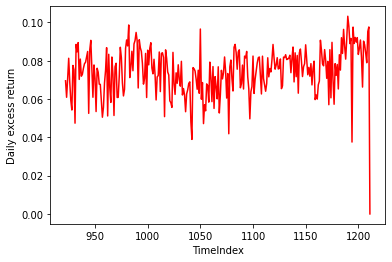

annual excess return = 27.08
annual excess volatility = 0.24
information ratio = 113.90


In [25]:
para.n_stock_select = 50
strategy = pd.DataFrame({'REV': [0] * (para.time_test[-1] + 1), 'value': [1] * (para.time_test[-1] + 1)})
print('4.Back Testing:')
for i_time in para.time_test:
    # -- get real and predicted return
    y_true_curr_day = y_true_test.iloc[:, i_time - 1]
    y_score_curr_day = y_score_test.iloc[:, i_time - 1]

    # -- sort predicted return, and choose the best 50
    y_score_curr_day = y_score_curr_day.sort_values(ascending=False)
    index_select = y_score_curr_day[0:para.n_stock_select].index

    # -- take the average return as the return of next month
    strategy.loc[i_time - 1, 'REV'] = np.mean(y_true_curr_day[index_select])

# -- compute the compund value of the strategy
strategy['value'] = (strategy['REV'] + 1).cumprod()

# -- plot the value
import matplotlib.pyplot as plt

plt.xlabel('TimeIndex')
plt.ylabel('Daily excess return')
plt.plot(para.time_test, strategy.loc[para.time_test, 'REV'], 'r-')
plt.show()

# -- evaluation
ann_excess_return = np.mean(strategy.loc[para.time_test, 'REV']) * 365
ann_excess_vol = np.std(strategy.loc[para.time_test, 'REV']) * np.sqrt(365)
info_ratio = ann_excess_return / ann_excess_vol

print('annual excess return = %.2f' % ann_excess_return)
print('annual excess volatility = %.2f' % ann_excess_vol)
print('information ratio = %.2f' % info_ratio)